<a href="https://colab.research.google.com/github/vinhpeters/tf-exam/blob/main/06_transfer_learning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scaling up Transfer Learning Models

## Import helper functions

In [71]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-09 19:04:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-09 19:04:42 (108 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [72]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, unzip_data


## 101 Food Classes

In [53]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-04-09 18:55:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G  23.5MB/s    in 68s     

2023-04-09 18:56:53 (22.9 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [54]:
unzip_data('101_food_classes_10_percent.zip')

In [55]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [56]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/filet_mignon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/paella'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and 75 image

In [57]:
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 7575 files belonging to 101 classes.


In [58]:
checkpoint_path = '101_classes_10_percent_data_model_checpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_weights_only=True, save_best_only=True)

In [59]:
# Data augmentation layers
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
], name='data_augmentation')


In [60]:

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)



In [61]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [62]:
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [63]:
history=model.fit(train_data_all_10_percent, epochs = 5 , steps_per_epoch= len(train_data_all_10_percent), validation_data=test_data, validation_steps = 0.15 * len(test_data), callbacks =[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 41s 141ms/step - loss: 3.3626 - accuracy: 0.2705 - val_loss: 2.3333 - val_accuracy: 0.5130
Epoch 2/5
237/237 [==============================] - 31s 127ms/step - loss: 2.1969 - accuracy: 0.5017 - val_loss: 1.7947 - val_accuracy: 0.6033
Epoch 3/5
237/237 [==============================] - 28s 117ms/step - loss: 1.8225 - accuracy: 0.5745 - val_loss: 1.5202 - val_accuracy: 0.6389
Epoch 4/5
237/237 [==============================] - 28s 116ms/step - loss: 1.5965 - accuracy: 0.6099 - val_loss: 1.3906 - val_accuracy: 0.6693
Epoch 5/5
237/237 [==============================] - 28s 116ms/step - loss: 1.4433 - accuracy: 0.6404 - val_loss: 1.2419 - val_accuracy: 0.6979


In [64]:
results=model.evaluate(test_data)

237/237 [==============================] - 17s 73ms/step - loss: 1.2044 - accuracy: 0.6947


## Fine-tuning

In [65]:
base_model.trainable = True

In [66]:
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [67]:
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [68]:
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_6 False
2 normalization_3 False
3 rescaling_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [69]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10
history_all_fine = model.fit(train_data_all_10_percent, epochs = fine_tune_epochs , steps_per_epoch= len(train_data_all_10_percent), validation_data=test_data, validation_steps = 0.15 * len(test_data), initial_epoch = history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 38s 128ms/step - loss: 1.2087 - accuracy: 0.6874 - val_loss: 1.0483 - val_accuracy: 0.7118
Epoch 6/10
237/237 [==============================] - 31s 129ms/step - loss: 1.0991 - accuracy: 0.7055 - val_loss: 0.9442 - val_accuracy: 0.7457
Epoch 7/10
237/237 [==============================] - 26s 109ms/step - loss: 1.0065 - accuracy: 0.7317 - val_loss: 0.9016 - val_accuracy: 0.7561
Epoch 8/10
237/237 [==============================] - 27s 111ms/step - loss: 0.9580 - accuracy: 0.7417 - val_loss: 0.8253 - val_accuracy: 0.7786
Epoch 9/10
237/237 [==============================] - 27s 111ms/step - loss: 0.8873 - accuracy: 0.7649 - val_loss: 0.8274 - val_accuracy: 0.7734
Epoch 10/10
237/237 [==============================] - 25s 105ms/step - loss: 0.8327 - accuracy: 0.7773 - val_loss: 0.7764 - val_accuracy: 0.7917


In [70]:
fine_tuned_results=model.evaluate(test_data)

237/237 [==============================] - 17s 70ms/step - loss: 0.7819 - accuracy: 0.7822


[0.7818984389305115, 0.7821782231330872]

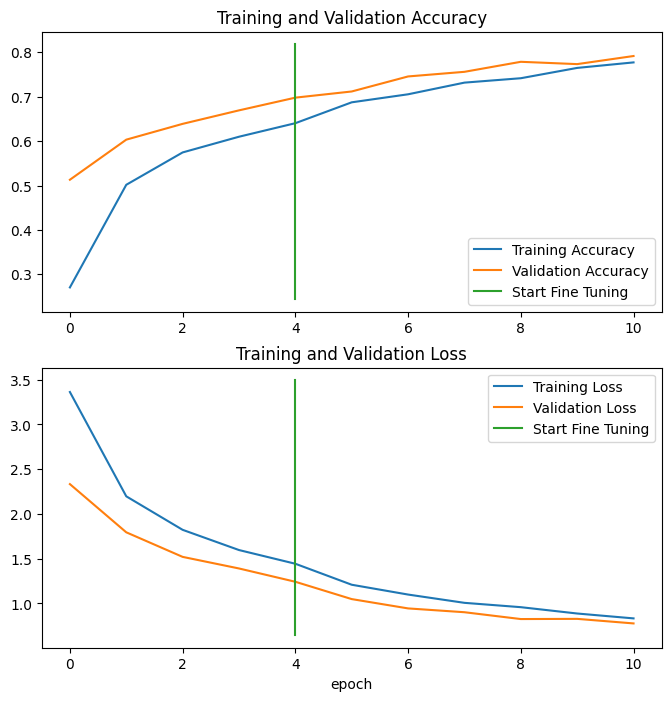

In [73]:
compare_historys(history,history_all_fine)